In [2]:
import pickle
import math
import matplotlib
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import self_driving_car.yuv_colorspace # TWE
%matplotlib inline

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

Modules loaded.


    labels[img_counter,1] = steering_angle;
    labels[img_counter,2] = throttle;
    labels[img_counter,3] = brake; 

In [3]:
def plot_image(image, caption, gray=False):
    plt.figure(figsize=(6,6))
    plt.tick_params(axis='x',labelbottom='off')
    plt.tick_params(axis='y',labelleft='off')
    if gray:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.title(caption)
    plt.show()

In [3]:
with open('/mnt/data2/train_pretrain.p', 'rb') as f:
    data = pickle.load(f)

# Load the feature data to the variable X_train
X_train = data['features']
# Load the label data to the variable y_train
y_train = data['labels']
# Load additional features (velocity)
z_train = data['features_more']

X_pretrain = X_train

In [4]:
# Number of training examples
n_train = len(X_train)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train)) # RAUS!

assert(len(X_train) == len(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 53
Image data shape = (64, 128, 3)
Number of classes = 10


In [5]:
# Shuffle the data
from sklearn.utils import shuffle
X_train, y_train, z_train = shuffle(X_train, y_train, z_train) 

In [6]:
# Load test data
X_test = np.empty([0, 64, 128, 3]);
y_test = np.empty([0, 1]);
for i in range(1,5):
    with open('/mnt/data/test_%d.p' % i, 'rb') as f:
        data_test = pickle.load(f)

    X_test = np.append(X_test, data_test['features'], axis=0)
    y_test = np.append(y_test, data_test['labels'])

X_test.shape

(4000, 64, 128, 3)

In [7]:
def preprocess_img(img):
    img = img.astype(float)/255.0
    img = yuv_colorspace.rgb2yuv(img) # convert to YUV colorspace
    img[:,:,0] = img[:,:,0] - 0.5; # remove mean
    return img

X_train_norm = np.empty_like(X_train, dtype='float32')
for index in range(len(X_train)):
    X_train_norm[index] = preprocess_img( X_train[index] )

X_test_norm = np.empty_like(X_test, dtype='float32')
for index in range(len(X_test)):
    X_test_norm[index] = preprocess_img( X_test_norm[index] ) 
    
print((X_train_norm.dtype))

float32


In [9]:
from keras.preprocessing.image import ImageDataGenerator
import random

def generateBatchRandom(USE_DATAGEN = False, TRAIN_HIGH_STEERING = True):
    I_MAX = 43;
    I_MAX = 8; # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<       
    I_MAX = 9; # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<   
    c = 0;
    
    if USE_DATAGEN:
        datagen = ImageDataGenerator(
            featurewise_center=True, # set input mean to 0 over the dataset
            samplewise_center=False, # set each sample mean to 0
            featurewise_std_normalization=True, # divide inputs by std of the dataset
            samplewise_std_normalization=False, # divide each input by its std
            zca_whitening=False, # apply ZCA whitening
            rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
            horizontal_flip=True, # randomly flip images
            vertical_flip=False) # randomly flip images

    while True:
        i = c % I_MAX;
        c = c + 1;        
        # print("Loading " + "/mnt/data/train_%d.p" % (i+1));
        with open("/mnt/data3/train_%d.p" % (i+1), "rb") as f: # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            train = pickle.load(f)
        X_train, y_train = train['features'], train['labels']
        if c == 0 and USE_DATAGEN:
            # Compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).
            # let's say X_sample is a small-ish but statistically representative sample of your data
            datagen.fit(X_train)
            
        X_train_norm = np.empty_like(X_train, dtype='float32')
        for index in range(len(X_train)):
            X_train_norm[index] = preprocess_img( X_train[index] )
        
        if TRAIN_HIGH_STEERING:
            N_EXTRA = 500;
            idx_extra = np.where(np.abs(y_train) > 0.3)[0]
#            print(idx_extra)                       
            # idx_rand = random.sample(set(idx_extra), N_EXTRA)
            idx_rand = [random.randint(0, len(idx_extra)) for x in range(N_EXTRA)]
            X_extra = X_train_norm[idx_rand]
            y_extra = y_train[idx_rand] 
#            print(X_train2[idx_rand].shape)                        
            X_train_norm = np.concatenate((X_train_norm,X_extra), axis=0)
            y_train = np.concatenate((y_train,y_extra), axis=0)            
            
        #X_train.shape
        if USE_DATAGEN:
            datagen.flow(X_train, y_train, batch_size=3000)
            for i in range(3000):
                yield next(datagen)
        else:
            yield (X_train_norm, y_train)

(1500, 64, 128, 3)
[-0.48668236 -0.47572941 -0.46927059 ...,  0.49725097  0.49769804
  0.49821177]


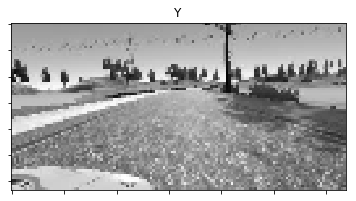

In [10]:
train_batch_gen = generateBatchRandom();
train_batch = next(train_batch_gen)
X_train_batch_norm = train_batch[0]
y_train_batch_norm = train_batch[1]
print(X_train_batch_norm.shape)
print( np.unique(X_train_batch_norm[500,:,:,0]) )
plot_image((X_train_batch_norm[500,:,:,0] + 0.5), 'Y', True)

(64, 128, 3)


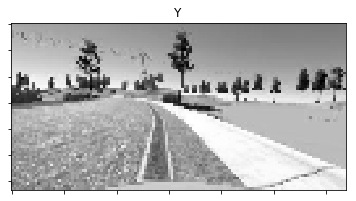

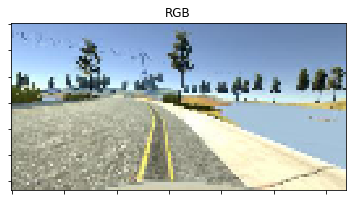

In [11]:
import pickle
with open("foo.p", "rb") as f:
    drive = pickle.load(f)   
    drive = drive[0,:,:,:];
print(drive.shape)
drive[:,:,0] = drive[:,:,0] + 0.5;
plot_image(drive[:,:,0],'Y',True)
plot_image(yuv_colorspace.yuv2rgb(drive),'RGB',False)

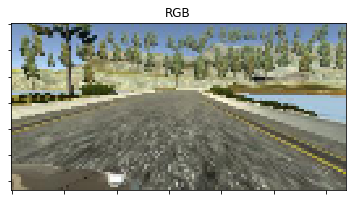

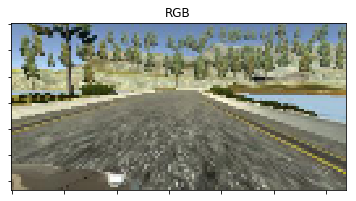

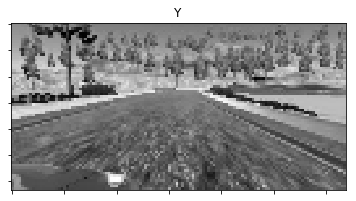

In [12]:
with open("/mnt/data/train_1.p", "rb") as f:
    train = pickle.load(f)
X_train2, y_train2 = train['features'], train['labels']
plot_image(X_train2[500]*-1,'RGB',False)
img2 = preprocess_img(X_train2[500]);
img2[:,:,0] = img2[:,:,0] + 0.5;
plot_image(yuv_colorspace.yuv2rgb(img2),'RGB',False)
plot_image(img2[:,:,0],'Y',True)

In [13]:
print(np.min(X_train_norm[:,:,:,0]), np.max(X_train_norm[:,:,:,0]))
print(np.min(X_train_norm[:,:,:,1]), np.max(X_train_norm[:,:,:,1]))
print(np.min(X_train_norm[:,:,:,2]), np.max(X_train_norm[:,:,:,2]))
assert math.isclose(np.min(X_train_norm), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_train_norm), 0.5, abs_tol=1e-5)

-0.5 0.494502
-0.28268 0.166046
-0.1748 0.438531


AssertionError: 

In [14]:
y_train_norm = y_train[:,0]
print( "min = {}, mean = {}, max = {}".format( np.min(y_train_norm), np.mean(y_train_norm), np.max(y_train_norm) ) )

min = -1.0, mean = 0.2345911962264151, max = 0.7666666999999999


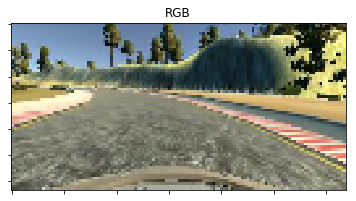

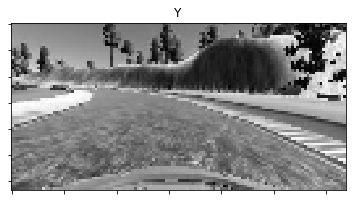

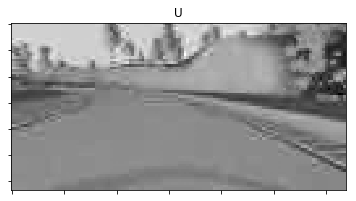

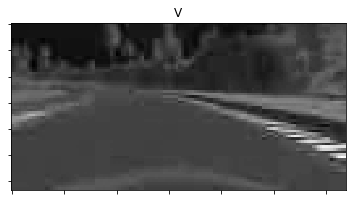

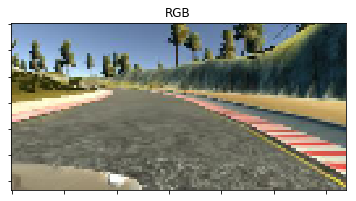

In [15]:
i = 3
plot_image(X_train[i]*-1, 'RGB', False)
plot_image(X_train_norm[i,:,:,0],'Y', True)
plot_image(X_train_norm[i,:,:,1],'U', True)
plot_image(X_train_norm[i,:,:,2],'V', True)
plot_image(X_test[i]*-1, 'RGB', False)

X_test = None
X_train = None

# Build Keras model

![logo](./images/NVIDIA_architecture.png)
We use strided convolutions in the
first three convolutional layers with a 2x2 stride and a 5x5 kernel and a non-strided convolution
with a 3x3 kernel size in the last two convolutional layers.

https://arxiv.org/pdf/1511.07289v1.pdf

In [16]:
# Build a model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.core import Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

In [17]:
X_train_norm[0].shape

(64, 128, 3)

In [18]:
def model_commaAI():
#    ch, row, col = 3, 160, 320  # camera format
    ch, row, col = 3, 64, 128  # camera format
    use_dropout = True

    model = Sequential()
#    model.add(Lambda(lambda x: x,
#            input_shape=(row, col, ch),
#           output_shape=(row, col, ch)))
#    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))  
    with tf.name_scope('conv2D_1'):
        model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", input_shape=(row, col, ch)))
#        model.add(BatchNormalization())
    model.add(ELU())
    with tf.name_scope('conv2D_2'): 
        model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
#        model.add(BatchNormalization())        
    model.add(ELU())
    with tf.name_scope('conv2D_3'):    
        model.add(Convolution2D(64, 5, 5, subsample=(5, 5), border_mode="same"))
#        model.add(BatchNormalization())        
    model.add(Flatten())
    if use_dropout: # NEU
        model.add(Dropout(.2)) # NEU    
#    model.add(ELU()) # NEU
#    model.add(Dense(600)) # NEU
#    if use_dropout:
#        model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    if use_dropout:    
        model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(20))    
    model.add(ELU())    
    model.add(Dense(1))

    # TODO: LR = 0.0001
    model.compile(optimizer="adam", loss="mse", metrics=['accuracy'])

    return model

In [22]:
def model_nvidia2():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, input_shape=(64, 128, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(36, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 5, 5))
    model.add(MaxPooling2D((2, 2)))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
#   model.add(ELU())

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dropout(0.5))
    model.add(Activation('elu'))
    model.add(Dense(100))
    model.add(Activation('elu'))
    model.add(Dense(50))
    model.add(Activation('elu'))
    model.add(Dense(10))
    model.add(Activation('elu'))
    model.add(Dense(1))

    # Compile and train the model
    model.compile('adam', 'mse')
    return model

In [23]:
def model_nvidia(self, input_shape=(64, 128, 3), learning_rate=0.001, dropout_prob=0.5, activation='elu',
                use_weights=False):
    model = None
    if use_weights:
        model = self.restore()
    if model is None:
        model = Sequential()
        model.add(Lambda(lambda x: x*1.0,
                         input_shape=input_shape,
                         output_shape=input_shape))
        model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", activation=activation))
        model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", activation=activation))
        model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", activation=activation))
        model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", activation=activation))
        model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", activation=activation))
        model.add(Flatten())
        model.add(Dropout(dropout_prob))
        model.add(Dense(1164, activation=activation))
        model.add(Dropout(dropout_prob))
        model.add(Dense(100, activation=activation))
        model.add(Dense(50, activation=activation))
        model.add(Dense(1, activation=activation))

    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [24]:
# Working with large datasets like Imagenet #68
# https://github.com/fchollet/keras/issues/68

#model = model_nvidia([64,128,3])
model = model_commaAI()
history = model.fit(X_train_norm, y_train_norm, nb_epoch=100, validation_split=0)

Epoch 1/100
33/33 [==============================] - 1s - loss: 0.3899 - acc: 0.3030     
Epoch 2/100
33/33 [==============================] - 0s - loss: 0.2316 - acc: 0.3030     
Epoch 3/100
33/33 [==============================] - 0s - loss: 0.1481 - acc: 0.3636     
Epoch 4/100
33/33 [==============================] - 0s - loss: 0.1160 - acc: 0.3333     
Epoch 5/100
33/33 [==============================] - 0s - loss: 0.0933 - acc: 0.3636     
Epoch 6/100
33/33 [==============================] - 0s - loss: 0.0710 - acc: 0.3636     

In [25]:
1/0

ZeroDivisionError: division by zero

In [19]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
#from keras import callbacks

#checkpoint_callback = ModelCheckpoint("./output/model.hdf5", verbose=1, save_best_only=True);
checkpoint_callback = ModelCheckpoint("./output/weights.{epoch:02d}-{val_loss:.4f}.hdf5", verbose=1);
tensorboard_callback = TensorBoard(log_dir='./output/tb_log/');

In [20]:
model = model_commaAI()
model.load_weights("./output/model.h5")

In [21]:
model.optimizer.lr.assign(0.0002);

In [24]:
#model.fit_generator(generate_arrays_from_file('/my_file.txt'), samples_per_epoch=10000, nb_epoch=10)
# Fit the model on the batches generated by datagen.flow().
#                    samples_per_epoch=42*1500,
with tf.name_scope('train'):
    history = model.fit_generator(generateBatchRandom(),
                    samples_per_epoch=9*1500,
                    nb_epoch=10,
                    validation_data=(X_test_norm, y_test),
                    callbacks=[checkpoint_callback, tensorboard_callback]);

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/10
13500/13500 [==============================] - 7s - loss: 0.0249 - acc: 0.5377 - val_loss: 0.0701 - val_acc: 0.3647
Epoch 2/10
13500/13500 [==============================] - 7s - loss: 0.0240 - acc: 0.5345 - val_loss: 0.0593 - val_acc: 0.3647
Epoch 3/10
13500/13500 [==============================] - 7s - loss: 0.0226 - acc: 0.5425 - val_loss: 0.0633 - val_acc: 0.3647
Epoch 4/10
13500/13500 [==============================] - 7s - loss: 0.0222 - acc: 0.5393 - val_loss: 0.0459 - val_acc: 0.3647
Epoch 5/10
13500/13500 [==============================] - 7s - loss: 0.0205 - acc: 0.5364 - val_loss: 0.0483 - val_acc: 0.3647
Epoch 6/10
13500/13500 [==============================] - 7s - loss: 0.0189 - acc: 0.5398 - val_loss: 0.0529 - val_acc: 0.3647
Epoch 7/10
13500/13500 [==============================] - 7s - loss: 0.0185 - acc: 0.5378 - val_loss: 0.0772 - val_acc: 0.3647
Epoch 8/10
13500/13500 [=====================

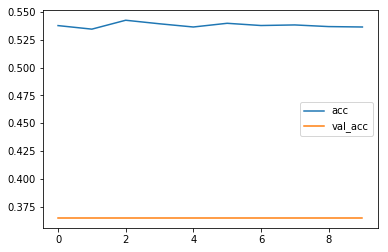

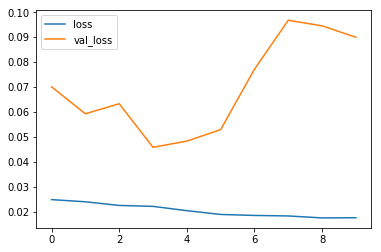

In [25]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc','val_acc'])
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [26]:
import json
model.save_weights("./output/model.h5")
with open('./output/model.json', 'w') as f:
    json.dump(model.to_json(), f)

51/53 [===========================>..] - ETA: 0s

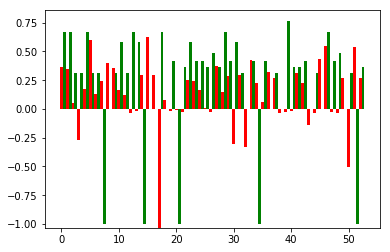

In [66]:
pred_steering = model.predict(X_train_norm, batch_size=1, verbose=1).squeeze()

fig, ax = plt.subplots()
ind = np.array(range(len(y_train_norm)));
width = 0.5;
ax.bar(ind, pred_steering, width, color='r')
ax.bar(ind + width, y_train_norm, width, color='g')
plt.show()

Predicted steering: 0.368 (correct 0.667)


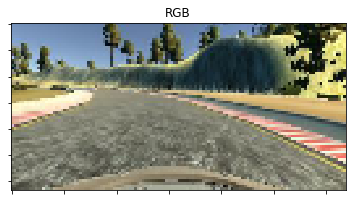

Predicted steering: 0.348 (correct 0.667)


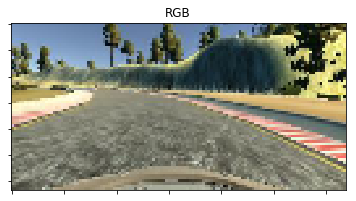

Predicted steering: 0.050 (correct 0.317)


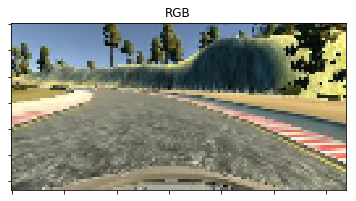

Predicted steering: -0.273 (correct 0.317)


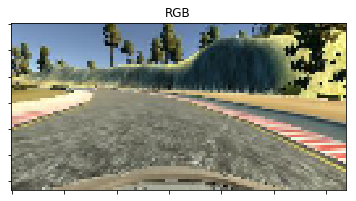

Predicted steering: 0.177 (correct 0.667)


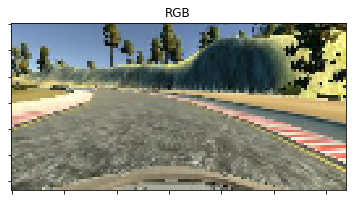

Predicted steering: 0.601 (correct 0.317)


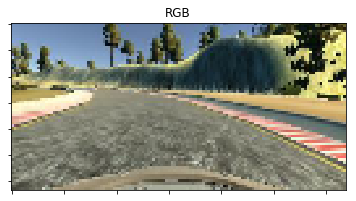

Predicted steering: 0.128 (correct 0.317)


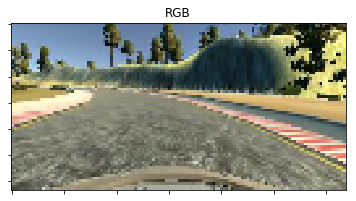

Predicted steering: 0.241 (correct -1.000)


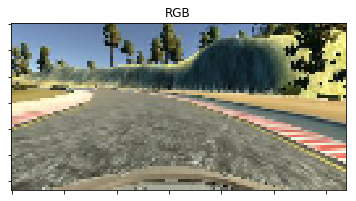

Predicted steering: 0.403 (correct 0.000)


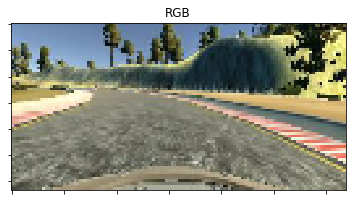

Predicted steering: 0.352 (correct 0.317)


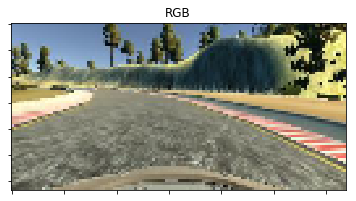

In [67]:
for i in range(10):
    print( "Predicted steering: %.3f (correct %.3f)" % ( pred_steering[i], y_train_norm[i] ) )
    plot_image(X_pretrain[i]*-1, 'RGB', False)

In [62]:
import pydot_ng
from keras.utils.visualize_util import plot
model.summary()
plot(model, to_file='model.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 16, 32, 16)    3088        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
elu_6 (ELU)                      (None, 16, 32, 16)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 8, 16, 32)     12832       elu_6[0][0]                      
____________________________________________________________________________________________________
elu_7 (ELU)                      (None, 8, 16, 32)     0           convolution2d_5[0][0]            
___________________________________________________________________________________________

![logo](./model.png)

In [38]:
assert history.history['val_loss'][-1] > 0.92, 'The training accuracy was: %.3f. It shoud be greater than 0.92' % history.history['val_loss'][-1]
assert history.history['loss'][-1] > 0.85, 'The validation accuracy is: %.3f. It shoud be greater than 0.85' % history.history['loss'][-1]
print('Tests passed.')

AssertionError: The training accuracy was: 0.039. It shoud be greater than 0.92

In [ ]:
# TODO: Load test data
with open('./data/test.p', 'rb') as f:
    data_test = pickle.load(f)

X_test = data_test['features']
y_test = data_test['labels']

# TODO: Preprocess data & one-hot encode the labels
X_normalized_test = normalize_grayscale(X_test)
y_one_hot_test = label_binarizer.fit_transform(y_test)

# TODO: Evaluate model on test data
metrics = model.evaluate(X_normalized_test, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

In [ ]:
  model.add(BatchNormalization())
    
    model.add(Convolution2D(16, 5, 5, subsample=(4, 4), border_mode="same")
    model.add(Activation('relu')())
    model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode="same")
    model.add(Activation('relu')())
    model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same")
              
    #model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Convolution2D(24, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    #model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Convolution2D(36, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    #model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Convolution2D(48, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dense(10))
    model.add(ELU())
model.add(Dense(1))
        
model.add(Flatten())

In [ ]:
# Source: https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
datagen = ImageDataGenerator(
        featurewise_center=True, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=True, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True, # randomly flip images
        vertical_flip=False) # randomly flip images

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
# let's say X_sample is a small-ish but statistically representative sample of your data
datagen.fit(X_train)
datagen.fit(X_sample) 

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch,
validation_data=(X_test, Y_test))        

# let's say you have an ImageNet generator that yields ~10k samples at a time.
for e in range(nb_epoch):
    print("epoch %d" % e)
    for X_train, Y_train in ImageNet(): # these are chunks of ~10k pictures
        for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=32): # these are chunks of 32 samples
            loss = model.train(X_batch, Y_batch)

# Alternatively, without data augmentation / normalization:
for e in range(nb_epoch):
    print("epoch %d" % e)
    for X_train, Y_train in ImageNet(): # these are chunks of ~10k pictures
        model.fit(X_batch, Y_batch, batch_size=32, nb_epoch=1)

In [ ]:
def generateBatchRandom(trainData):

    batchImg = np.zeros((BATCHSIZE, IMG_Y, IMG_X, 3))
    batchSteer = np.zeros(BATCHSIZE)
    while 1:
        for i in range(BATCHSIZE):
            i_data = np.random.randint(len(trainData))
            img = Image.open(trainData[i_data]['img'])
            batchImg[i] = preprocessImg(img, flip=trainData[i_data]['flip'], addShdw=True, randBright=True)
            batchSteer[i] = trainData[i_data]['steer']
    yield batchImg, batchSteer

In [ ]:
def generate_arrays_from_file(path):
    while 1:
        f = open(path)
        for line in f:
            # create numpy arrays of input data
            # and labels, from each line in the file
            x, y = process_line(line)
            img = load_images(x)
            yield (img, y)
        f.close()


In [ ]:
# Normalize the data features to the variable X_normalized
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

# X_normalized = normalize_grayscale(X_train)

In [ ]:
def model_nvidia():
    ch, row, col = 3, 64, 128  # original model format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
              input_shape=(row, col, ch),
              output_shape=(row, col, ch)))
    model.add(Convolution2D(24, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(36, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(48, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dense(100))
    model.add(ELU())
    model.add(Dense(50))
    model.add(ELU())
    model.add(Dense(10))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
whos

In [ ]:
del X_test
del X_train
del X_train2
del X_train_batch_norm
del X_train_batch

In [ ]:
import psutil
import sys
psutil.virtual_memory()
for var, obj  in locals().items():
    if sys.getsizeof(obj) > 10000:
        print("%20s: %d" % (var, sys.getsizeof(obj)))

In [ ]:
del _121
del model

In [ ]:
import gc
gc.collect()

In [ ]:
last = 0
alpha = 2.5
plt.figure()
#plt.hold()
for i in range(100):
    new = np.random.randn(1) + 10*math.sin(i/10)
    if not i % 10: new = new * 2
    a = (1-1/alpha)*last + 1/alpha*new
    last = a
    plt.plot(i,new,'r.')    
    plt.plot(i,a,'b.')
plt.show()    

In [ ]:
()

# Model Class

In [76]:
from imp import reload
import self_driving_car
from self_driving_car import data_generator
reload(self_driving_car.data_generator)
datagen = self_driving_car.data_generator.DataGenerator()
datagen.add_dataset("dataset1_udacity")
datagen.add_dataset("dataset2_twe_one_lap")
datagen.add_dataset("dataset3_ssz_one_lap")
datagen.prepare();
gen = datagen.get_batch_generator()

2175 samples removed due to speed < 10


/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:233: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  fwd = pd.stats.moments.ewma( self.data.steering.values, span=window )
/home/carnd/CarND-Behavioral-Cloning-P3/self_driving_car/data_generator.py:234: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  bwd = pd.stats.moments.ewma( self.data.steering.values[::-1], span=window )


steering angle has been smoothed based on window 12
higher probabilities for steering samples (sum of p = 1.000000)
shuffled data
split data into 47147 training sample and 5238 validation samples


In [ ]:
from self_driving_car import model, yuv_colorspace
reload(self_driving_car)
reload(self_driving_car.model)
model = self_driving_car.model.SDRegressionModel()
history = model.train_generator(datagen, "foo5", nb_epoch = 20)

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/20
47092/47147 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.0000e+00  

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1537: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to /mnt/models//commaAI_modified/weights/foo5/weights.00-0.0035.hdf5
47285/47147 [==============================] - 329s - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0035 - val_acc: 0.0000e+00
Epoch 2/20
47285/47147 [==============================] - 288s - loss: 0.0021 - acc: 0.0000e+00 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 8/20
47285/47147 [==============================] - 287s - loss: 0.0019 - acc: 0.0000e+00 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 9/20
47285/47147 [==============================] - 286s - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 10/20
47285/47147 [==============================] - 289s - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 11/20
47285/47147 [==============================] - 295s - loss: 0.0017 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 12/20
47285/47147 [==============================] - 293s - loss: 0.0016 - acc: 0.0000

In [ ]:
# TODO: Predict image sequence from rec folder + plot

# Testing

In [176]:
from keras import backend as K
#K.image_dim_ordering()

'tf'

(193, 128, 128, 3)
(193, 68, 128, 3)


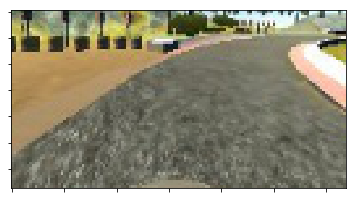

0.306309919196


In [72]:
reload(self_driving_car.model)
#input_data = np.ones((10,128,128,3))
model = self_driving_car.model.SDRegressionModel.model_crop()
print(batch[0].shape)
pred = model.predict(batch[0])
print(pred.shape)
i = 23
plot_image(denormalize(pred[i,:,:,:]), "")
print(batch[1][i])

In [30]:
batch = next(gen)
print(batch[0].shape)
print(batch[1].shape)

(193, 128, 128, 3)
(193,)


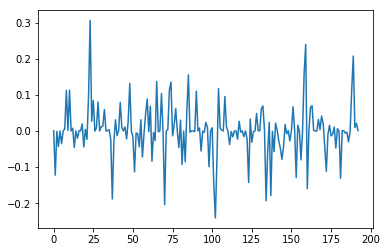

In [31]:
plt.figure()
plt.plot(batch[1])
plt.show()

img         dataset1_udacity/IMG_preprocessed/mod_flip_cen...
steering                                            0.0962224
throttle                                             0.985533
brake                                                       0
speed                                                 30.1832
cam                                                         C
filter                                               mod_flip
weight                                            3.74741e-05
is_train                                                 True
Name: 16828, dtype: object
dataset1_udacity/IMG_preprocessed/mod_flip_center_2016_12_01_13_38_19_321.jpg
(128, 128, 3) (128, 128, 3)
uint8 float64
mean: [ 128.33538818  133.26403809  124.64093018] [ 0.01296995 -0.01190022 -0.00850431]
min:  [0 4 0] [-0.48520784 -0.21603866 -0.13352591]
max:  [255 255 255] [ 0.49769804  0.12327863  0.25759781]


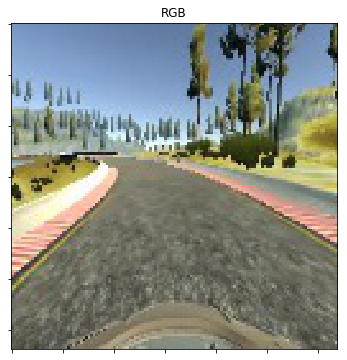

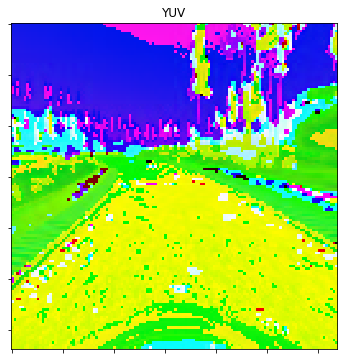

In [144]:
import cv2
row = datagen.data[datagen.data['is_train'] == True].iloc[100]
print(row)
print(row['img'])
img_raw = cv2.imread(datagen.basepath + "/" + row['img'])
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB) # OpenCV does not use RGB, it uses BG
img_norm = self_driving_car.DataGenerator.normalize(img_raw);
print(img_raw.shape, img_norm.shape)
print(img_raw.dtype, img_norm.dtype)
print("mean:",np.mean(img_raw,axis=(0,1)),np.mean(img_norm,axis=(0,1)))
print("min: ",np.min(img_raw,axis=(0,1)),np.min(img_norm,axis=(0,1)))
print("max: ",np.max(img_raw,axis=(0,1)),np.max(img_norm,axis=(0,1)))
plot_image(img_raw,"RGB")
plot_image(img_norm,"YUV")

In [13]:
def denormalize(img):
    img = img.copy()
    img[:,:,0] = img[:,:,0] + 0.5;      # remove mean    
    img = self_driving_car.yuv_colorspace.yuv2rgb(img)   # convert to YUV colorspace
    img = img * 255
    return img.astype(np.uint8)

def crop(img):
#    return img[:, 45:-15, :]
    return img[45:-15, :, :]

img = batch[0][109];
img = crop(img)
#img = img_norm;
img_org = denormalize2(img)
print(img.shape)
print("mean:",np.mean(img,axis=(0,1)))
print("min: ",np.min(img,axis=(0,1)))
print("max: ",np.max(img,axis=(0,1)))
plot_image(img[:,:,0],'Y',True)
#plot_image(img[:,:,1],'U',True)
#plot_image(img[:,:,2],'V',True)
plot_image(img_org,'RGB',False)
print(img_org.shape, img_org.dtype)
#img_org
print(np.mean(img_raw-img_org,axis=(0,1)))
print(img_raw[0:5,0:5,0])
print(img_org[0:5,0:5,0])

NameError: name 'batch' is not defined

In [87]:
test1 = self_driving_car.yuv_colorspace.yuv2rgb(img_raw/255)
test2 = np.array(self_driving_car.yuv_colorspace.rgb2yuv(test1)*255).astype(np.uint8)
#plot_image(test1,"1")
#plot_image(test2,"2")
#plot_image(test1-test2,"diff")
np.mean(img_raw-test2)

0.1256103515625

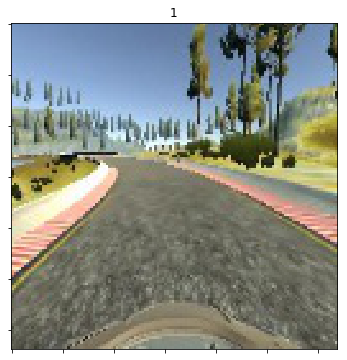

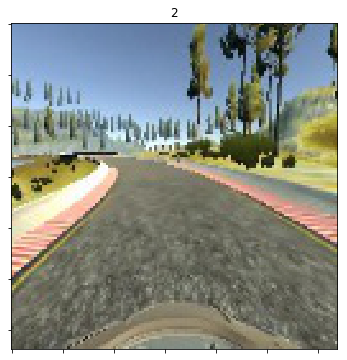

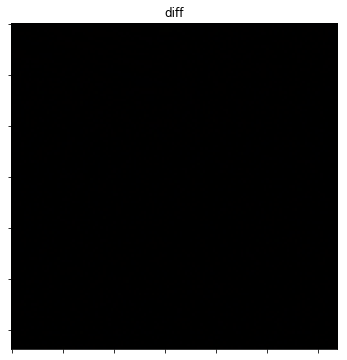

[[118 117 116 115 115 114 114 113 112 112]
 [119 118 117 116 116 115 115 114 113 115]
 [120 120 119 118 118 117 117 116 117 117]
 [123 122 121 120 120 120 119 120 119 119]
 [124 124 123 122 122 123 122 122 121 121]
 [126 125 124 123 125 124 123 123 122 122]
 [128 127 126 125 126 126 125 124 123 123]
 [129 129 128 127 128 127 126 126 125 125]
 [130 129 128 128 128 128 127 127 126 126]
 [132 131 130 130 129 128 127 129 128 128]]
[[118 116 115 115 115 113 113 113 111 111]
 [119 118 116 115 115 115 115 113 113 114]
 [120 120 119 118 118 116 116 115 117 117]
 [123 121 121 120 120 120 119 120 119 119]
 [123 123 123 121 121 123 121 121 121 121]
 [125 125 123 123 125 123 123 123 121 121]
 [128 127 125 125 126 126 125 123 123 123]
 [129 129 128 127 128 127 126 126 125 125]
 [130 129 128 128 128 128 127 127 126 126]
 [131 131 130 130 129 128 127 129 128 128]]


0.1256103515625

In [86]:
test1 = self_driving_car.yuv_colorspace.yuv2rgb(img_raw.astype(float)/255.0)
test2 = (self_driving_car.yuv_colorspace.rgb2yuv(test1)*255).astype(np.uint8)
plot_image(img_raw,"1")
plot_image(test2,"2")
plot_image(img_raw-test2,"diff")
np.mean(img_raw-test2,axis=(0,1))
print(img_raw[0:10,0:10,0])
print(test2[0:10,0:10,0])
np.mean(img_raw-test2)

In [138]:
def test(x):
    x[:] = x[:] + 0.5;
    return 2

x = np.array([1,2,3])
print(x)
y = test(x)
print(x)
print(y)

[1 2 3]
[1 2 3]
2


(160, 320, 3) uint8 0 255


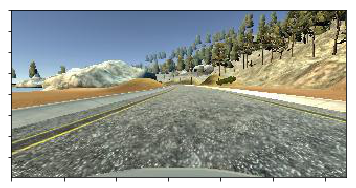

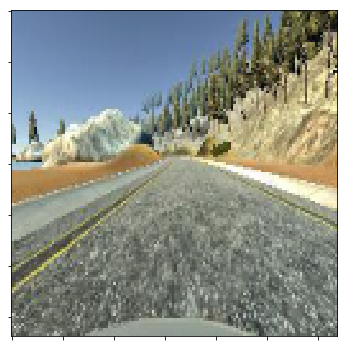

In [19]:
import cv2
from drive import preprocess_img
img = cv2.imread('./rec/2017_02_07_06_35_01_145.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.asarray(img)
print(img.shape, img.dtype, np.min(img), np.max(img))
plot_image(img,'')
pimg = preprocess_img( img );
#plot_image(pimg,'')
img2 = denormalize(pimg);
plot_image(img2,'')

In [28]:
from keras.models import load_model
image_array = preprocess_img( img );
model = load_model("./comma_model1/weights/foo3/weights.02-0.0021.hdf5")
steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))
print(steering_angle)

-0.05041978508234024


(1, 68, 128, 3)


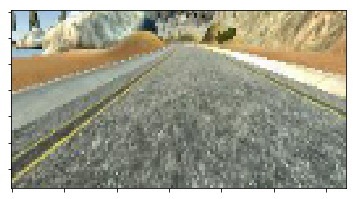

In [27]:
import self_driving_car
from self_driving_car.model import SDRegressionModel
model = self_driving_car.model.SDRegressionModel.model_crop()
pred = model.predict(image_array[None, :, :, :], batch_size=1)
print(pred.shape)
plot_image(denormalize(pred[0,:,:,:]), "")

In [10]:
import numpy as np
x = np.ones([10],dtype=bool)
y = np.logical_not(x)
print(x)
print(y)

[ True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False False]


In [ ]:
import numpy as np
data = datagen.data.copy();
#data = data.reindex(np.random.permutation(data.index))
data.loc[data['filter'] == 'mod_shadow', ('is_train', 'is_valid')] = False
data.loc[data['filter'] == 'mod_blur', ('is_train', 'is_valid')] = False
data.loc[data['filter'] == 'mod_flip', ('is_train', 'is_valid')] = False
data.loc[data['cam'] == 'C', 'steering'] += 1000.0
#data.loc[data['cam'] == 'R', 'steering'] -= offset
data
#data[data['cam'] == 'L']

In [ ]:
import pandas as pd
csv = pd.read_csv('/mnt/data/dataset1_udacity/driving_log.csv')
for i in csv.columns:
    if isinstance(csv[i][1], str):
        csv[i] = csv[i].map(str.strip)

In [11]:
print(csv['left'][0])
x = 'JA' if isinstance(csv['left'][0], str) else 'NEIN'
print(x)
num_of_cams = 1
if isinstance(csv['left'][0], str): num_of_cams += 1;
if isinstance(csv['right'][0], str): num_of_cams += 1;
num_of_cams
num_of_filters = 1
num_of_samples = len(csv) * num_of_cams * num_of_filters

for i in range(10):
    left_img        = csv['left'][i];
    right_img       = csv['right'][i];
    center_img      = csv['center'][i];
    
    for camera, img_path in (('L', left_img), ('R', right_img), ('C', center_img)):
        if not camera == 'C' and num_of_cams == 1:
            continue
        print(img_path)

NameError: name 'csv' is not defined

In [ ]:
x = np.zeros([3,2])
x.shape != (3,2)

In [ ]:
from self_driving_car.model import SDRegressionModel
reload(self_driving_car.model)
SDRegressionModel.model_architecture("commaAI")['normalizer']